In [11]:
import gym
import os
from stable_baselines.results_plotter import load_results
from seagul.plot import smooth_bounded_curve
import matplotlib.pyplot as plt
import numpy as np
import torch
import pybullet_envs
from stable_baselines import TD3 as ALGO
import time
import seagul.envs
import pybullet as p
import json
import pybulletgym

#env_name = "Walker2d-v2"
#env_name = "Walker2DBulletEnv-v0"
#env_name = "pbmj_walker2dfc-v0"
env_name = "Walker2DMuJoCoEnv-v0"

def do_rollout_stable(init_point=None, render=False):
    env = gym.make(env_name, render=render,**config)
    model.observation_space = env.observation_space
    obs=env.reset()
    #td3_model = TD3.load(script_path + "../rl-baselines-zoo/baseline_log2/td3/su_acrobot_cdc-v0_2/su_acrobot_cdc-v0.zip")

    obs = torch.as_tensor(obs, dtype=torch.float32)

    acts_list = []
    obs1_list = []
    rews_list = []

    dtype = torch.float32
    act_size = env.action_space.shape[0]
    obs_size = env.observation_space.shape[0]

    done = False
    cur_step = 0

#    import ipdb; ipdb.set_trace()

    while not done:
        acts = model.predict(obs)[0]


        obs, rew, done, out = env.step(acts)

        
        if render:
        #    env.render()
            time.sleep(.02)
            
        obs1_list.append(obs)
        obs = torch.as_tensor(obs, dtype=dtype)

        acts_list.append(torch.as_tensor(acts))
        rews_list.append(torch.as_tensor(rew, dtype=dtype))
        cur_step += 1

    ep_obs1 = torch.tensor(obs1_list)
    ep_acts = torch.stack(acts_list)
    ep_rews = torch.stack(rews_list)
    p.disconnect()

    return ep_obs1, ep_acts, ep_rews

Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.


<Figure size 432x288 with 0 Axes>

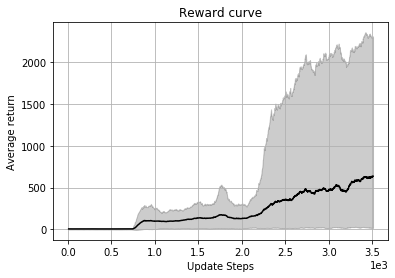

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [6]:
# %%
fig, ax = plt.subplots(1,1)

#log_dir = script_path + './walker_log'
df_list = []
model_list = []
min_length = float('inf')

#trial_path = "/home/sgillen/work/lorenz/run_stable/data/mj15/td30/"
trial_path = "/home/sgillen/work/contact/run_stable/data_pb/td32/"


for entry in os.scandir(trial_path):
    if ".ipynb" in entry.path:
        continue
    if "config" in entry.path:
        config = json.load(open(entry.path))
        continue
    
    df = load_results(entry.path)


    if len(df['r']) < min_length:
        min_length = len(df['r'])

    #plt.plot(df['r'])
    plt.figure()
    df_list.append(df)
    model_list.append(ALGO.load(entry.path + "/model.zip"))

min_length = int(min_length)
rewards = np.zeros((min_length, len(df_list)))

for i, df in enumerate(df_list):
    rewards[:, i] = np.array(df['r'][:min_length])

smooth_bounded_curve(rewards[:min_length], ax=ax)
 
ax.grid()
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
#fig.savefig(script_path + '../figs/reward.png')
plt.figure() 

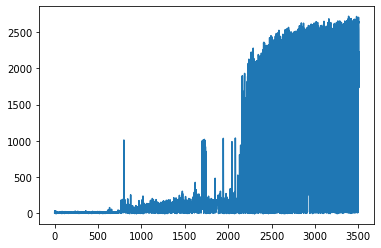

WalkerBase::__init__
reward sum: 2578.1181640625


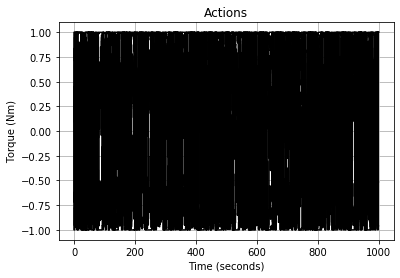

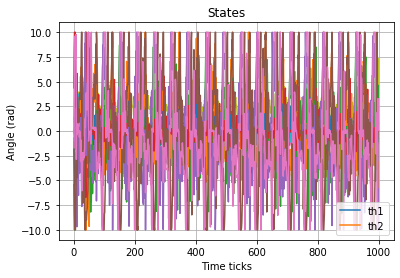

In [12]:
model = model_list[7]
df = df_list[7]
plt.plot(df['r']); plt.show()

obs_hist, act_hist, rew_hist = do_rollout_stable(render=True)

print(f"reward sum: {sum(rew_hist)}")

plt.step([i for i in range(act_hist.shape[0])], act_hist, 'k')
plt.title('Actions')
plt.xlabel('Time (seconds)')
plt.ylabel('Torque (Nm)')
plt.grid()
#plt.savefig(script_path + '../figs/act_hist.png')
plt.show(); plt.figure()

plt.plot(obs_hist)

plt.title('States')
plt.xlabel('Time ticks')
plt.ylabel('Angle (rad)')
plt.legend(['th1', 'th2'])
plt.grid()
#plt.savefig(script_path + '../figs/obs_hist.png')
plt.show()